# Convert CSV to Xarray and example plots

In [107]:
%matplotlib inline
import xarray as xr
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [108]:
savename = "predictions/timeseries.nc"

In [109]:
CSVlist = os.listdir('predictions/prediction_CSV')
CSVlist.remove('.DS_Store')

for n, CSVfile in enumerate(CSVlist):
    print('Adding',n+1,'/',len(CSVlist),':',CSVfile)
    times = []
    prediction = []
    predconf = []
    fogconf = []
    iceconf = []
    noconf = []

    data = pd.read_csv(os.path.join('predictions/prediction_CSV',CSVfile),header=None)
    for i in range(len(data)):
        times.append(pd.to_datetime(str(data.iloc[i,0])[:-2]))
        prediction.append(int(data.iloc[i,1]))
        predconf.append(data.iloc[i,2])
        fogconf.append(data.iloc[i,3])
        iceconf.append(data.iloc[i,4])
        noconf.append(data.iloc[i,5])
    
    new_ds = xr.Dataset(
         {
             "prediction": (["time"], prediction),
             "prediction_confidence": (["time"], predconf),
             "fog_confidence": (["time"], fogconf),
             "ice_confidence": (["time"], iceconf),
             "no_confidence": (["time"], noconf)
         },
         coords={
             "time": times,
         },
     )
    if n == 0:
        ds = new_ds
    else:
        ds = xr.concat([ds, new_ds], dim='time')

ds.to_netcdf(savename)
print('Saved as',savename)

Adding 1 / 403 : 20150712.csv
Adding 2 / 403 : 20150706.csv
Adding 3 / 403 : 20160821.csv
Adding 4 / 403 : 20150909.csv
Adding 5 / 403 : 20170830.csv
Adding 6 / 403 : 20120829.csv
Adding 7 / 403 : 20120815.csv
Adding 8 / 403 : 20120626.csv
Adding 9 / 403 : 20110901.csv
Adding 10 / 403 : 20130804.csv
Adding 11 / 403 : 20130805.csv
Adding 12 / 403 : 20100722.csv
Adding 13 / 403 : 20110914.csv
Adding 14 / 403 : 20120627.csv
Adding 15 / 403 : 20190906.csv
Adding 16 / 403 : 20170616.csv
Adding 17 / 403 : 20200611.csv
Adding 18 / 403 : 20140528.csv
Adding 19 / 403 : 20160808.csv
Adding 20 / 403 : 20150711.csv
Adding 21 / 403 : 20200820.csv
Adding 22 / 403 : 20200808.csv
Adding 23 / 403 : 20200613.csv
Adding 24 / 403 : 20190723.csv
Adding 25 / 403 : 20170614.csv
Adding 26 / 403 : 20100522.csv
Adding 27 / 403 : 20120816.csv
Adding 28 / 403 : 20110916.csv
Adding 29 / 403 : 20130621.csv
Adding 30 / 403 : 20130806.csv
Adding 31 / 403 : 20110903.csv
Adding 32 / 403 : 20110917.csv
Adding 33 / 403 :

Adding 261 / 403 : 20130529.csv
Adding 262 / 403 : 20110809.csv
Adding 263 / 403 : 20120909.csv
Adding 264 / 403 : 20130908.csv
Adding 265 / 403 : 20130707.csv
Adding 266 / 403 : 20110831.csv
Adding 267 / 403 : 20170928.csv
Adding 268 / 403 : 20140814.csv
Adding 269 / 403 : 20180629.csv
Adding 270 / 403 : 20180601.csv
Adding 271 / 403 : 20150622.csv
Adding 272 / 403 : 20200913.csv
Adding 273 / 403 : 20150805.csv
Adding 274 / 403 : 20210527.csv
Adding 275 / 403 : 20160722.csv
Adding 276 / 403 : 20170530.csv
Adding 277 / 403 : 20170524.csv
Adding 278 / 403 : 20150810.csv
Adding 279 / 403 : 20170518.csv
Adding 280 / 403 : 20200721.csv
Adding 281 / 403 : 20180827.csv
Adding 282 / 403 : 20200912.csv
Adding 283 / 403 : 20180628.csv
Adding 284 / 403 : 20160904.csv
Adding 285 / 403 : 20160521.csv
Adding 286 / 403 : 20170726.csv
Adding 287 / 403 : 20110818.csv
Adding 288 / 403 : 20110830.csv
Adding 289 / 403 : 20120515.csv
Adding 290 / 403 : 20130712.csv
Adding 291 / 403 : 20100606.csv
Adding 2

In [42]:
ds = xr.open_dataset(savename)

## Example plots

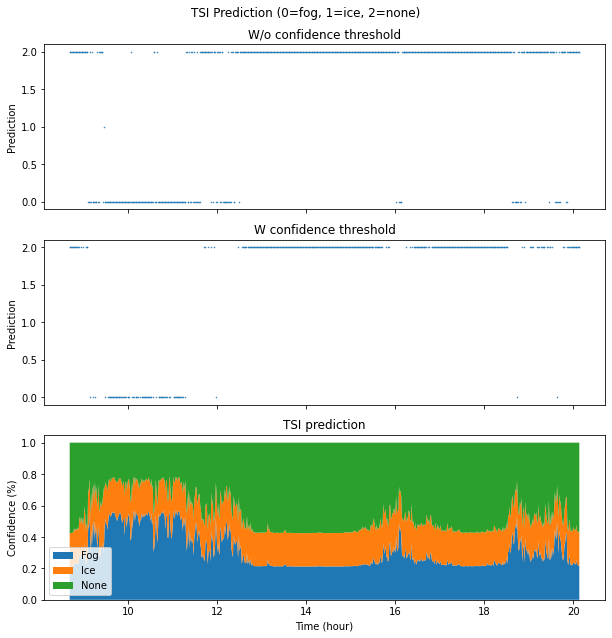

In [234]:
# plot a specific day of predictions

time = '20110926'
conf = 0.5

ds_sel = ds.sel(time=time)
ds_sel_con = ds.where(ds.prediction_confidence > conf).sel(time=time)

fig, ax = plt.subplots(3,1,figsize=(8.6,9),sharex=True)
ax[0].scatter(ds_sel.time,ds_sel.prediction,s=1,marker='.')
ax[0].set_title('W/o confidence threshold')
#ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Prediction')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax[1].scatter(ds_sel_con.time,ds_sel_con.prediction,s=1,marker='.')
ax[1].set_title('W confidence threshold')
ax[1].set_ylabel('Prediction')
#ax[1].set_xlabel('Time (hour)')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.suptitle('TSI Prediction (0=fog, 1=ice, 2=none)')

# Lookup the prediction distribution over selected time

ax[2].stackplot(ds_sel.time, [ds_sel.fog_confidence,ds_sel.ice_confidence,ds_sel.no_confidence],
             labels=['Fog','Ice','None'])
ax[2].legend(loc='lower left')
ax[2].set_title('TSI prediction')
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Confidence (%)')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.tight_layout()
plt.show()

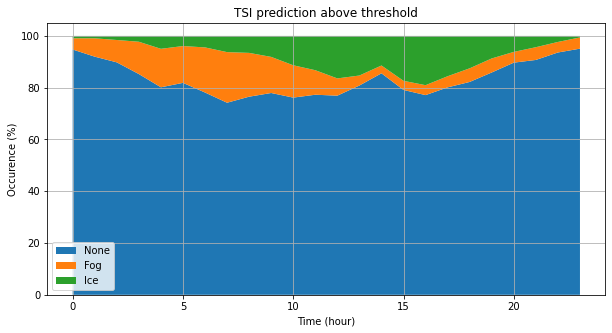

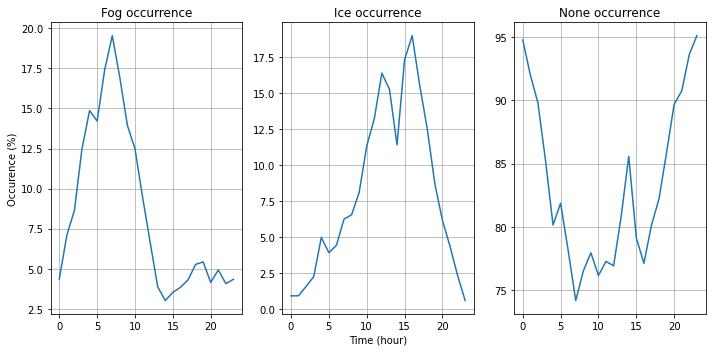

In [114]:
# fog/ice/none average distribution over all data (daily) above confidence threshold

conf = 0.5

totoccur = ds.prediction.where(ds.prediction_confidence>conf).groupby('time.hour').count()
fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.hour, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction above threshold')
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Occurence (%)')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.grid()

plt.show()

# When does fog/ice/none occur?

fig, ax = plt.subplots(1,3, sharex=True, sharey=False,figsize=(10,5))
ax[0].plot(fogoccur.hour, fogoccur)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')
ax[0].grid()

ax[1].plot(iceoccur.hour, iceoccur)
ax[1].set_title('Ice occurrence')
ax[1].set_xlabel('Time (hour)')
ax[1].grid()

ax[2].plot(nonoccur.hour, nonoccur)
ax[2].set_title('None occurrence')
ax[2].grid()

plt.tight_layout()
plt.show()

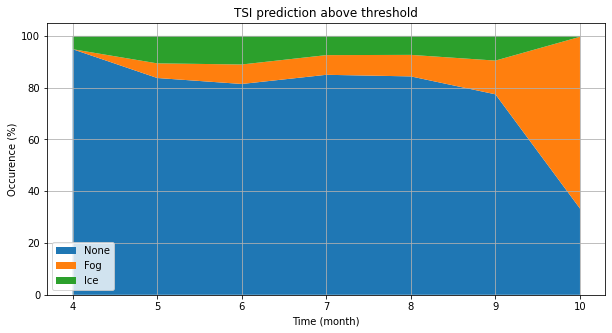

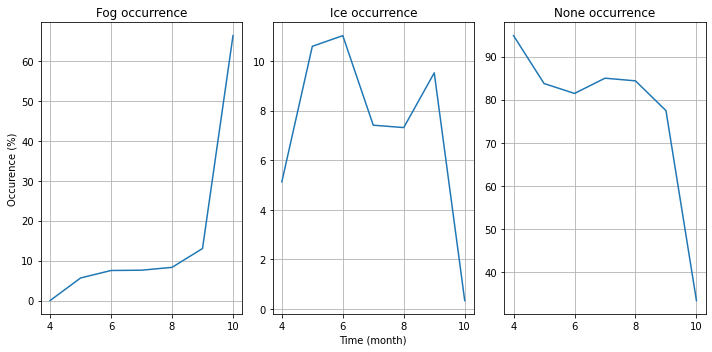

In [116]:
# which months does fog occur?

conf = 0.5

totoccur = ds.prediction.where(ds.prediction_confidence>conf).groupby('time.month').count()
fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.month, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction above threshold')
ax.set_xlabel('Time (month)')
ax.set_ylabel('Occurence (%)')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.grid()

plt.show()


fig, ax = plt.subplots(1,3, sharex=True, sharey=False,figsize=(10,5))
ax[0].plot(fogoccur.month, fogoccur)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')
ax[0].grid()
#ax[0].set_xlim(5,9)

ax[1].plot(iceoccur.month, iceoccur)
ax[1].set_title('Ice occurrence')
ax[1].set_xlabel('Time (month)')
ax[1].grid()

ax[2].plot(nonoccur.month, nonoccur)
ax[2].set_title('None occurrence')
ax[2].grid()

plt.tight_layout()
plt.show()

In [117]:
totoccur

<xarray.DataArray 'prediction' (month: 7)>
array([  2165,  49082, 115994, 113404,  92956,  56662,    591])
Coordinates:
  * month    (month) int64 4 5 6 7 8 9 10

Month 10 is based on very little data, 4 too